# Exploring Azure AI search in Fabric: A practical step-by-step guide

## Introduction

In the context of building your RAG application in Microsoft Fabric, search capabilities are crucial for retrieving relevant data to enhance the performance. This tutorial is designed to guide you through the various Azure AI search types that you can leverage within Microsoft Fabric. By understanding these search types, you'll you'll learn how to evaluate different types of Azure AI search and you'll be better equipped to integrate the right search functionality into your RAG application, ensuring it efficiently retrieves and processes the most relevant data.

The Azure AI search types that are covered in this tutorial include:

1. Simple (keyword-based) search 
2. Vector (embedding-based) search
3. Filtered vector search 
4. Semantic ranking of results on keyword-based search
5. Hybrid search: combination of simple search and vector search

You can assess the search needs of your RAG application, considering factors like data types, query complexity, and scalability requirements and then implement and integrate the best search solution into your RAG application in Microsoft Fabric.

The summary of the main steps you take in this notebook - as depicted in the diagram below - are as following:


1. Set up Azure OpenAI and Azure AI Search Services
2. Load the data from CMU's QA dataset of Wikipedia articles to curate a benchmark
3. Analyze pre-built search configuration
4. Experiment with different types of Azure AI search
5. Select the best-performing type of Azure AI search in the RAG application


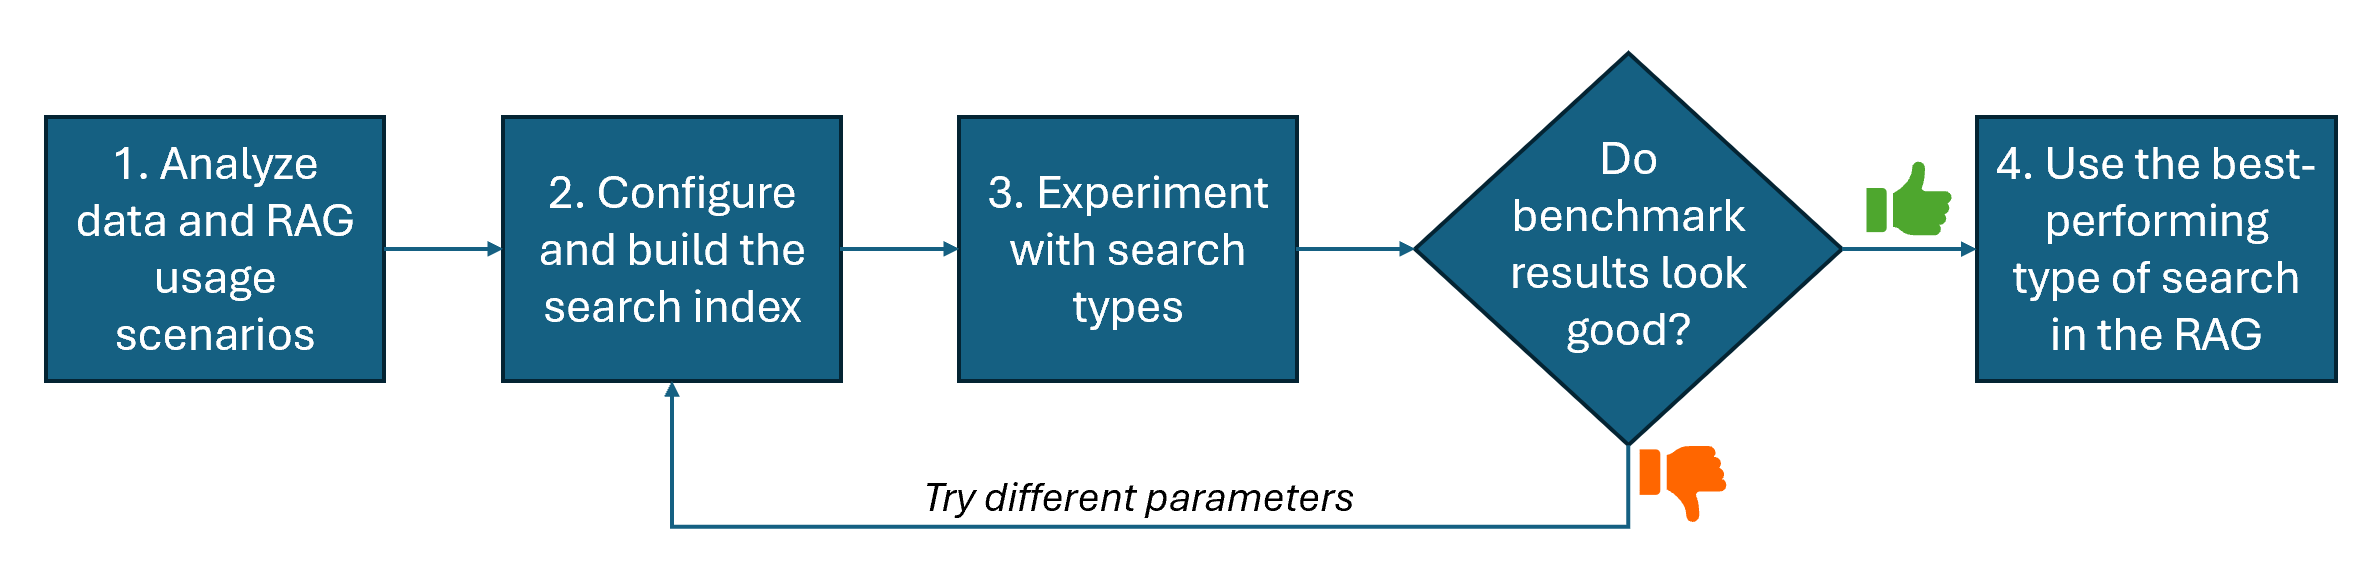

### Prerequisites

You need the following services to run this notebook:

- [Microsoft Fabric](https://aka.ms/fabric/getting-started)
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook (it should have data populated with steps from previous tutorials).
- [Azure AI Studio for OpenAI](https://aka.ms/what-is-ai-studio)
- [Azure AI Search](https://aka.ms/azure-ai-search) (it should have data populated with steps from previous tutorials).

> [!IMPORTANT]
> **Prior to starting this tutorial, please complete "Building Retrieval Augmented Generation in Fabric: [A Step-by-Step Guide"](https://aka.ms/fabric/quickstart-genai-guidance).**

In the previous tutorial, you have uploaded data to your lakehouse and built an index of documents that is in the backend of the RAG application. The index will be used here as part of an exercise to learn the main techniques for evaluation of RAG performance. If you haven't done this yet, or have removed the previously created index, please follow the steps in this [tutorial](https://aka.ms/fabric/quickstart-genai-guidance) to complete the prerequisite.

## Step 1: Overview of Azure Setup


#### Set up Azure OpenAI and Azure AI Search Keys

To set up Azure OpenAI and Azure AI Search Services, you need to have an Azure subscription. If you don't have one, you can create a free account [here](https://aka.ms/azure-free-account-overview). 

Once you have an Azure subscription, you can follow the instructions [here](https://aka.ms/openai-create-deploy) to learn how to create an Azure OpenAI Service. 

In this section, you will define the endpoints and necessary keys to set up your Azure services. For deploying your own OpenAI models outside of Fabric, [Azure AI Studio for OpenAI](https://aka.ms/what-is-ai-studio) is recommended. Two models are required for RAG: `text-embedding-ada-002` for embedding and `gpt-4-32k` or a similar chat model. Please provide the specific names and keys for these models in the following.

Once done with setting up your Azure OpenAI Service, you need to set up your Azure AI Search which offers a user-friendly interface to create a vector database in Azure. Since you already have an Azure subscription, you can also create an Azure AI Search Service by following the instructions [here](https://aka.ms/azure-ai-search).

You may choose a free tier for the Azure AI Search Service, which allows you to have 3 indexes and 50 MB of storage. The free tier is sufficient for this tutorial. You will need to select a subscription, set up a resource group, and name the service. Once configured, obtain the keys to specify as `aisearch_api_key`. Please complete the details for `aisearch_index_name`, etc in the following. 

<img src="https://appliedaipublicdata.blob.core.windows.net/cmuqa-08-09/output/Azure_AI_Search_Free_Tier.png" style="width:800px;"/>


In [ ]:

# Fill in the following lines with your Azure OpenAI service information
aoai_endpoint = "https://.openai.azure.com" # TODO: Provide the url endpoint for your created Azure OpenAI
aoai_key = "" # TODO: Fill in your API key from Azure OpenAI 
aoai_deployment_name_embeddings = "text-embedding-ada-002"
aoai_model_name_query = "gpt-4-32k"
aoai_api_version = "2024-02-01"

# Setup key accesses to Azure AI Search
aisearch_index_name = "" # TODO: Create a new index name: must only contain lowercase, numbers, and dashes
aisearch_api_key = "" # TODO: Fill in your API key from Azure AI Search
aisearch_endpoint = "https://.search.windows.net" # TODO: Provide the url endpoint for your created Azure AI Search 

Once you have setup your Azure OpenAI and Azure AI Search Keys, you must import required libraries from [Spark](https://spark.apache.org/), [SynapseML](https://aka.ms/AboutSynapseML), [Azure Search](https://aka.ms/azure-search-libraries), and OpenAI. 

Make sure to use the `environment.yaml` from the same location as this notebook file to upload into Fabric to create, save, and publish a [Fabric environment](https://aka.ms/fabric/create-environment). Then select the newly created environment before running the cell below for imports.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import copy, os, requests, json, warnings

from datetime import datetime, timedelta
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, current_timestamp, concat, col, split, explode, udf, monotonically_increasing_id, when, rand, coalesce, lit, input_file_name, regexp_extract, concat_ws, length, ceil, lit, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, ArrayType, FloatType
from pyspark.sql import Row
import pandas as pd
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import (
    VectorizedQuery,
)
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,   
    SemanticConfiguration,  
    SemanticPrioritizedFields,
    SemanticField,  
    SemanticSearch,
    VectorSearch,  
    HnswAlgorithmConfiguration,
    HnswParameters,  
    VectorSearchProfile,
    VectorSearchAlgorithmKind,
    VectorSearchAlgorithmMetric,
)

import openai 
from openai import AzureOpenAI
import uuid
import matplotlib.pyplot as plt
from synapse.ml.featurize.text import PageSplitter
import ipywidgets as widgets  
from IPython.display import display as w_display

## Step 2: Load the data into the Lakehouse and create a benchmark

### Dataset

The Carnegie Mellon University Question-Answer dataset version 1.2 is a corpus of Wikipedia articles, manually-generated factual questions based on the articles, and manually-generated answers. The data is hosted on an Azure blob storage under the same license [GFDL](http://www.gnu.org/licenses/fdl.html). For simplicity, the data is cleaned up and refined into a single structured table with the following fields.

- ArticleTitle: the name of the Wikipedia article from which questions and answers initially came.
- Question: manually generated question based on article
- Answer: manually generated answer based on question and article
- DifficultyFromQuestioner: prescribed difficulty rating for the question as given to the question-writer
- DiffuctlyFromAnswerer: Difficulty rating assigned by the individual who evaluated and answered the question, which may differ from the difficulty from DifficultyFromQuestioner
- ExtractedPath: path to original article. There may be more than one Question-Answer pair per article
- text: cleaned wikipedia artices

For more information about the license, please download a copy of the license named `LICENSE-S08,S09` from the same location.

##### History and Citation

The dataset used for this notebook requires the following citation:

    CMU Question/Answer Dataset, Release 1.2

    8/23/2013

    Noah A. Smith, Michael Heilman, and Rebecca Hw

    Question Generation as a Competitive Undergraduate Course Project

    In Proceedings of the NSF Workshop on the Question Generation Shared Task and Evaluation Challenge, Arlington, VA, September 2008. 
    Available at: http://www.cs.cmu.edu/~nasmith/papers/smith+heilman+hwa.nsf08.pdf

    Original dataset acknowledgements:
    This research project was supported by NSF IIS-0713265 (to Smith), an NSF Graduate Research Fellowship (to Heilman), NSF IIS-0712810 and IIS-0745914 (to Hwa), and Institute of Education Sciences, U.S. Department of Education R305B040063 (to Carnegie Mellon).

    cmu-qa-08-09 (modified verison)

    6/12/2024

    Amir Jafari, Alexandra Savelieva, Brice Chung, Hossein Khadivi Heris, Journey McDowell

    Released under same license GFDL (http://www.gnu.org/licenses/fdl.html)
    All the GNU license applies to the dataset in all copies.

### Create Benchmark

In order to validate that the RAG application works as expected, you can create a benchmark using a subset of questions prepared by CMU students found in the `S08/set1` and `S08/set2` buckets. Limit it to one question per article by applying `df.dropDuplicates(["ExtractedPath"])` to the data. Additionally, remove any duplicate questions. The complexity labels for the questions were provided during the curation process; in this example, you'll limit them to `medium`.

In [ ]:
df = spark.sql("SELECT * FROM data_load_tests.cmu_qa")

# Filter the DataFrame to include only the specified paths
df = df.filter((col("ExtractedPath").like("S08/data/set1/%")) | (col("ExtractedPath").like("S08/data/set2/%")))

# Choose questions 
df = df.filter(col("DifficultyFromQuestioner") == "medium")

# Drop duplicate questions
df = df.dropDuplicates(["Question"])
df = df.dropDuplicates(["ExtractedPath"])

num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

# Persist the DataFrame
df.persist()
display(df)

As a result of this process, a dataframe with 20 rows is created, serving as the benchmark for this tutorial. Important fields include `Question`, `Answer` (the human-curated `ground truth answer`), and `ExtractedPath` (the source document where the information is found).

By adjusting the filtering criteria, you can incorporate other questions to increase diversity in complexity, creating a more realistic example. This can be a good exercise for additional experiments.

### Retriever and Response Generator

As mentioned in tutorial [A step-by-step guide to evaluate the performance of RAG applications in Fabric](https://aka.ms/fabric/quickstart-genai-guidance-evaluation), the performance evaluation of the RAG application targets its two main components: the `retriever` and the `response generator`. The functions defined below implement these two main components:

- the retriever: `get_context_source`
- the response generator: `get_answer`

You should already be familiar with the following code from the first [tutorial](https://aka.ms/fabric/quickstart-genai-guidance). Note the `topN` parameter lets you configure how many relevant resources to fetch from the index. In this tutorial, you will be using 3, but the optimal value may vary for different data and use cases.

In [ ]:
# Implementation of retriever
def get_context_source(retrieve_results, question, topN=3, filter=''):
    """
    Retrieves contextual information and sources related to a given question using embeddings and a vector search.  
    Parameters:
    retrieve_results (function): implements one of retrieval methods with Azure AI search
    question (str): The question for which the context and sources are to be retrieved.  
    topN (int, optional): The number of top results to retrieve. Default is 3.  
    filter (str, optional): The article title to filter retrieved chunks to. Default is '' (not applied).
    
    Returns:  
    List: A list containing two elements:  
        1. A string with the concatenated retrieved context.  
        2. A list of retrieved source paths.  
        3. A dataframe of retrieved chunks with metadata
    """

    results = retrieve_results(question, filter, topN)
    results_copy = copy.deepcopy(results)
    documents = [result for result in results_copy]
    df_chunks = pd.DataFrame(documents).drop(columns=['Embedding', '@search.highlights', '@search.captions'])

    retrieved_context = ""
    retrieved_sources = []
    for result in results:
        retrieved_context += result['ExtractedPath'] + "\n" + result['Chunk'] + "\n\n"
        retrieved_sources.append(result['ExtractedPath'])

    return [retrieved_context, retrieved_sources, df_chunks]

In [ ]:
# Implementation of response generator
def get_answer(question, context):
    """  
    Generates a response to a given question using provided context and an Azure OpenAI model.  
    
    Parameters:  
        question (str): The question that needs to be answered.  
        context (str): The contextual information related to the question that will help generate a relevant response.  
    
    Returns:  
        str: The response generated by the Azure OpenAI model based on the provided question and context.  
    """
    messages = [
        {
            "role": "system",
            "content": "You are a chat assistant who will be provided text information for grounding your response. Ground the answer only on the data provided to you in the context, otherwise reply you don't know. Always give a minimalistic succinct answer"
        }
    ]

    messages.append(
        {
            "role": "user", 
            "content": question + "\n" + context,
        },
    )

    chat_client = openai.AzureOpenAI(
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
        api_version=aoai_api_version,
    )

    chat_completion = chat_client.chat.completions.create(
        model=aoai_model_name_query,
        messages=messages,
    )

    return chat_completion.choices[0].message.content

Some questions are formulated with enough context to retrieve the correct article, such as, `Did Uruguay host the first-ever World Cup?`. 

However, other questions might lack sufficient context. For example, without knowing that the question `Can citizens propose changes to the Constitution?` is about `Uruguay`, the correct context might not be retrieved unless you explicitly limit the search space to information about Uruguay.

To address this, you can use the `ArticleTitle` field associated with each question in the dataset. The real-life equivalent of this would be using what you know about a particular user of the RAG system. For instance, if an employee of a multinational corporation inquires about the travel policy, it's reasonable to limit the document search space to those relevant to their country. However, in other scenarios, it might be better not to apply filters, such as when an employee wants to find information about the company's history.

In the following sections, you'll learn how to configure the search index to support both search and filtering, and how to implement and run different types of searches.

## Step 3: Analyze pre-built search configuration

### Configure the Search Index


Let's revisit how Azure AI Search that was configured in the first tutorial, [Building Retrieval Augmented Generation in Fabric: A Step-by-Step Guide](https://aka.ms/fabric/quickstart-genai-guidance). This section will give you a deeper understanding of what that code does and why search has been configured in specific ways to support different RAG usage scenarios.

In the code block below, you defined a data structure using a list of fields, specifying their types and attributes. The `Id` field serves as the key because it's unique by definition (generated with the `monotonically_increasing_id` function). You couldn't rely on `ArticleTitle` and `ExtractedPath` for uniqueness since there may be multiple text chunks within the same article, making the values non-unique across all rows.

It's also important to note that the fields `Id`, `Chunk`, and `Embedding` were defined with the `searchable=True` parameter. Similarly, `Id`, `ArticleTitle`, and `ExtractedPath` were also defined with the `searchable=True` parameter. These configurations are crucial as they determine the types of searches that will be possible once the index is created.

Here's the code block that was used for that:

```python 

fields = [
    SimpleField(name="Id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="ArticleTitle", type=SearchFieldDataType.String, filterable=True),
    SearchableField(name="ExtractedPath", type=SearchFieldDataType.String, filterable=True),
    SearchableField(name="Chunk", type=SearchFieldDataType.String, searchable=True),
    SearchField(name="Embedding",
                type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True,
                vector_search_dimensions=1536,
                vector_search_profile_name="my-vector-config"
    ),
]

```

#### 3.1. Simple (keyword-based) search

Keyword-based search uses exact word matching to retrieve documents based on specific keywords. It's efficient for precise searches but limited in understanding context and is best suited for scenarios where precise word matching is critical, such as legal document searches, or when the exact terminology is known.

The `Chunk` field contains the text that you want to retrieve during searches. To allow for simple keyword searches on this text field, you need to define it with the parameters `type=SearchFieldDataType.String` and `searchable=True`. This configuration ensures that the text within the Chunk field can be effectively searched using keywords. Among all the fields, only the Chunk field was configured this way to specifically support keyword-based search functionality.

#### 3.2. Vector (embedding-based) search 

Vector search aims to understand the semantic meaning of text. It is an important technique for identifying relevant pieces of information by analyzing and comparing semantic similarities. This method involves representing text data as vectors in a high-dimensional space, allowing for sophisticated matching based on meaning rather than just keywords. Vector search is ideal for more complex queries where the context or concept is more important than the specific wording, such as finding similar articles, recommendations

The `Embedding` field is designed to support vector-based searches, which are crucial for finding semantically similar content. Unlike other fields, the `Embedding` field is configured with the type `SearchFieldDataType.Collection(SearchFieldDataType.Single)`. This type allows the field to store collections of single-dimensional data points, which is essential for handling embeddings.

The `Embedding` field is set with `vector_search_dimensions=1536` because it uses the `text-embedding-ada-002` model, which generates embeddings with a fixed dimension of 1536. Additionally, this field references a vector search profile, specified by `vector_search_profile_name="my-vector-config"`, which is defined separately and will be explained in the following paragraph.

To enable vector search, the Hierarchical Navigable Small Worlds (HNSW) algorithm was configured by setting its parameters and creating a usage profile. One of the key parameters is `metric=VectorSearchAlgorithmMetric.COSINE`, which determines that cosine similarity will be used to measure the distance between different embeddings. This setup ensures that the search can effectively find and rank results based on how closely their meanings match, rather than just their keyword content.

```python

vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnsw",
            kind=VectorSearchAlgorithmKind.HNSW,
            parameters=HnswParameters(
                m=4,
                ef_construction=400,
                ef_search=500,
                metric=VectorSearchAlgorithmMetric.COSINE
            )
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="my-vector-config",
            algorithm_configuration_name="myHnsw",
        ),
    ]
)
```

#### 3.3. Filtered vector search 

Filtered vector search combines the capabilities of vector search with traditional filtering mechanisms to refine search results. In filtered vector search, you first apply a filter to narrow down the pool of documents based on structured criteria. Then, within that filtered set, the vector search is performed to find the most semantically relevant matches.

The fields `Id`, `ArticleTitle`, and `ExtractedPath` were all configured with the `filterable=True` parameter to enable filtering capabilities. This setup allows you to apply filters during searches, refining results based on specific criteria associated with these fields. However, for the purposes of this tutorial, only the `ArticleTitle` field will be utilized to demonstrate filtering. This choice will help you focus on how filtering can be applied in a practical scenario, making it easier to understand its impact on search results.

#### 3.4. Semantic ranking

Semantic ranking is a method that prioritizes search results based on their relevance to the meaning and context of a query, rather than just matching keywords. It involves understanding the meaning and context of both the search query and the documents, ensuring that the most contextually appropriate results are ranked higher.

You can improve the accuracy of semantic search by configuring settings that emphasize certain key fields. By giving more weight to these fields, the search engine delivers more relevant and meaningful results.

The semantic search configuration is defined as follows:

```python

# Note: Useful for reranking 
semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=SemanticPrioritizedFields(
        title_field=SemanticField(field_name="ArticleTitle"),
        prioritized_content_fields=[SemanticField(field_name="Chunk")]
    )
)

# Create the semantic settings with the configuration
semantic_search = SemanticSearch(configurations=[semantic_config])

```

#### 3.5. Hybrid search

Hybrid search combines the strengths of both keyword search and vector (semantic) search to deliver more comprehensive and relevant search results. It leverages the precision of keyword matching with the contextual understanding of vector search to enhance the overall search experience, which is especially beneficial for applications requiring high-quality, context-aware search functionality. Hybrid search can help users find documents that contain specific terms while also surfacing related documents that might not use the exact same language but are still relevant.

By configuring both keyword-based and vector search options appropriately when initializing the `SearchIndex`, you can utilize these combined search capabilities during runtime.

The following code snippet demonstrates how to create a search index with these configurations, ensuring that it supports the various search types discussed. The function responsible for initiating the creation of the index is `create_or_update_index`:

```python

# Create the search index with the semantic settings
index = SearchIndex(
    name=aisearch_index_name,
    fields=fields,
    vector_search=vector_search,
    semantic_search=semantic_search
)

index_client = SearchIndexClient(
    endpoint=aisearch_endpoint,
    credential=AzureKeyCredential(aisearch_api_key),
)

result = index_client.create_or_update_index(index)
print(f' {result.name} created')
```

Building a new search index is not covered in this tutorial. However, if you're interested in experimenting with modifying it, you can refer back to the first tutorial, [Building Retrieval Augmented Generation in Fabric: A Step-by-Step Guide](https://aka.ms/fabric/quickstart-genai-guidance). In that tutorial, you can make adjustments to the code based on your preferences. For example, you might want to change the distance measurement algorithm by updating the metric parameter to either `VectorSearchAlgorithmMetric.DOT_PRODUCT` or `VectorSearchAlgorithmMetric.EUCLIDEAN`. After making these changes, you can rerun the notebook to see the effects.

## Step 4: Experiment with different types of Azure AI search


Now that you've explored the different types of Azure AI search, you can evaluate their performance. To start, set `topN = 3` to specify the number of top matching results you want the search to return. This value will be used as the top parameter in the `search_client.search` function, indicating the number of best matches to retrieve from the search results. By configuring `topN` to 3, you instruct the search client to return only the three most relevant results based on your query.

In [ ]:
topN = 3
easy_question = "Did Uruguay host the first ever World Cup?" # Yes, in 1930
easy_question2 = "How many square kilometres of continental land is Uruguay?" # 176,214 square kilometres
hard_question = "Can citizens propose changes to the Constitution?" # Yes, people are allowed to challenge laws
article_title = "Uruguay"

It's important to note that some questions contain enough context to provide a clear answer on their own. For example, a straightforward question like `Did Uruguay host the first-ever World Cup?` is specific and self-contained, making it easy to answer accurately.

In contrast, more complex questions may lack sufficient context, leading to ambiguity and multiple possible answers. For instance, a question like `Can citizens propose changes to the Constitution?` may be unclear without additional information, such as knowing that it pertains to `Uruguay`. Without this context, the question could apply to various countries, each with different laws and procedures, resulting in several potentially `correct` answers.

#### 4.1. Simple (keyword-based) search

Begin by implementing a basic `keyword_search` function that utilizes the full text of the question as the search term. This approach leverages full-text search capabilities, allowing you to find relevant results based on the entire query text.

Keep in mind that full-text search can go beyond simple sentence matching. It supports advanced features such as boolean operators, wildcards, and other query syntax elements that can refine and enhance your search. For detailed information and additional options, refer to the [Azure documentation on keyword search syntax](https://aka.ms/fabric/quickstart-genai-guidance/keywordsearch).

In [ ]:
def keyword_search(question, filter='', topN=3):
    search_client = SearchClient(
        aisearch_endpoint,
        aisearch_index_name,
        credential=AzureKeyCredential(aisearch_api_key)
    )

    results = search_client.search(
        search_text = question,
        top=topN
    ) 

    return results

Evaluate the `keyword_search` function using a straightforward question to evaluate its performance. This initial test will help you understand how well the function handles basic queries and whether it retrieves relevant results based on the full text of the question.

In [ ]:
context, sources, df_chunks = get_context_source(keyword_search, easy_question2, topN)
df_chunks

Relevance scoring is a mechanism used to evaluate and rank search results based on their relevance to the current query. This is represented by the search score (`@search.score`), which indicates how well each item matches the search criteria. The score is unbounded, meaning there is no fixed upper limit; however, a higher score generally signifies that an item is more relevant to the query.

For keyword searches, the score reflects the degree of match between the search terms and the items in the index. The higher the score, the more pertinent the item is to the search query.

Note that the `@search.reranker_score` field will return `None` in this context. This field is relevant only when using semantic ranking, which involves more advanced ranking methods that consider the contextual meaning of the query and items.

See if the answers are correct for all the two question rated as `straightforward/easy` above and check that the chunks from the right article are fetched as context.

In [ ]:
answer = get_answer(easy_question2, context)
print(f"Answer: {answer}, sources: {sources}")

In [ ]:
context, sources, df_chunks = get_context_source(keyword_search, easy_question, topN)
answer = get_answer(easy_question, context)
print(f"Answer: {answer}, sources: {sources}")

In [ ]:
easy_question2_reformulated = "Did Uruguay ever host Coupe du Monde?"
context, sources, df_chunks = get_context_source(keyword_search, easy_question2_reformulated, topN)
answer = get_answer(easy_question2_reformulated, context)
print(f"Answer: {answer}, sources: {sources}")

You can now check whether the answer is correct for the question rated as `challenging/hard` above and check that the chunks from the right article are fetched as context.

In [ ]:
context, sources, df_chunks = get_context_source(keyword_search, hard_question, topN)
answer = get_answer(hard_question, context)
print(f"Answer: {answer}, sources: {sources}")

It's interesting to note that, despite the absence of the term `Uruguay` in the question itself, the keyword search still managed to locate the relevant answer within the appropriate article.

#### 4.2. Vector Search

Begin by implementing a basic `vector_search` function. This function will use vector representations to perform searches based on the semantic similarity of the query. Test this function using a straightforward question to evaluate how well it retrieves relevant information by analyzing the context and meaning of the query. This initial test will help you understand the effectiveness of vector search in finding and ranking results.

To learn more about how vector search works and its ranking mechanisms, you can read the detailed documentation at [Vector Search Ranking in Azure](https://aka.ms/fabric/quickstart-genai-guidance/vectorsearch-ranking).

In [ ]:
def vector_search(question, filter = '', topN = 3): 
    embed_client = openai.AzureOpenAI(
        api_version=aoai_api_version,
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
    )

    query_embedding = embed_client.embeddings.create(input=question, model=aoai_deployment_name_embeddings).data[0].embedding

    vector_query = VectorizedQuery(vector=query_embedding, k_nearest_neighbors=topN, fields="Embedding"  )

    search_client = SearchClient(
        aisearch_endpoint,
        aisearch_index_name,
        credential=AzureKeyCredential(aisearch_api_key)
    )

    results = search_client.search(   
        vector_queries=[vector_query],
        top=topN,
    )

    return results
 
context, sources, df_chunks = get_context_source(vector_search, easy_question2, topN)
df_chunks

When using the cosine metric in vector search, it's important to understand that the `@search.score` value returned by Azure AI Search is not the direct cosine similarity between the query vector and document vectors. Instead, Azure AI Search applies transformations to the raw cosine similarity values, ensuring that the score function remains monotonically decreasing. This means that as the similarity between the query and document vectors decreases, the `@search.score` will also decrease accordingly.

The range for vector similarity scores is standardized, typically spanning from `0.333` to `1.001`. This range is used to normalize the similarity scores, where a score of `1.00` indicates the highest possible similarity, representing an almost perfect match, while a score of `0.333` is the lower threshold for relevant results. Scores below this range are generally not considered relevant, ensuring that only meaningful results are presented based on their semantic similarity. This normalization helps in consistently interpreting the relevance of search results across different queries.

In [ ]:
answer = get_answer(easy_question2, context)
print(f"Answer: {answer}, sources: {sources}")

You've already seen that the answer to the `straightforward/easy` question is accurate. Now, try it on a more `challenging/hard` question to see how well the search handles complex queries.

In [ ]:
context, sources, df_chunks = get_context_source(vector_search, hard_question, topN)
answer = get_answer(hard_question, context)
print(f"Answer: {answer}, sources: {sources}")

You notice that the answer lacks specific details about `Uruguay`, indicating that the pure vector search didn't perform well on the `challenging/hard` question. This highlights a limitation of relying solely on vector search—it may not always capture the necessary contextual details, especially when those details are crucial for answering the query accurately. As a result, the search fails to provide comprehensive and relevant results in both scenarios.

### 4.3. Filtered vector search 

To enhance your search results, start by implementing a basic `filter_vector_search` function. This function will allow you to apply filters to your vector search, helping to refine the results and improve accuracy. After implementing the function, test it with a more `challenging/hard` question to see how well the filtered vector search handles complex queries. This approach can help you retrieve more relevant and contextually appropriate results.

You can find detailed documentation on how to add filters to vector searches at [Adding Filters to Vector Search](https://aka.ms/fabric/quickstart-genai-guidance/vector-search-filters).

In [ ]:
def filtered_vector_search(question, filter = '', topN = 3): 
    embed_client = openai.AzureOpenAI(
        api_version=aoai_api_version,
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
    )

    query_embedding = embed_client.embeddings.create(input=question, model=aoai_deployment_name_embeddings).data[0].embedding

    vector_query = VectorizedQuery(vector=query_embedding, k_nearest_neighbors=topN, fields="Embedding"  )

    search_client = SearchClient(
        aisearch_endpoint,
        aisearch_index_name,
        credential=AzureKeyCredential(aisearch_api_key)
    )

    results = search_client.search(   
        vector_queries=[vector_query],
        filter=f"(ArticleTitle eq '{filter}') ", 
        top=topN,
    )

    return results
 
context, sources, df_chunks = get_context_source(filtered_vector_search, hard_question, topN, article_title)
df_chunks

This time, you'll notice that the retrieved chunks are from the correct articles. Now, test whether these chunks provide enough information to fully answer the question. Evaluate the content to ensure that it not only comes from the right source, but also contains the necessary details to give a comprehensive and accurate response. This will help you determine the effectiveness of the filtered vector search in delivering relevant and complete answers.

In [ ]:
answer = get_answer(hard_question, context)
print(f"Answer: {answer}, sources: {sources}")

You can see that you successfully obtained the correct answer by using filtered vector search to retrieve relevant chunks from the appropriate article.

#### 4.4. Keyword search with semantic ranking

To get started, a basic implementation of this capability is provided in the `semantic_search` function below. Begin by testing it on a `straightforward/easy` question to see how effectively it ranks and retrieves the most relevant results. This initial test will help you gauge how well semantic search handles simple queries before moving on to more `challenging/hard` scenarios.

You can explore the intricacies of semantic ranking search in detail at [Azure Semantic Search Overview](https://aka.ms/fabric/quickstart-genai-guidance/semantic-search-overview).

In [ ]:
def semantic_search(question, filter = '', topN = 3):  
    search_client = SearchClient(
        aisearch_endpoint,
        aisearch_index_name,
        credential=AzureKeyCredential(aisearch_api_key)
    )

    results = search_client.search(
        query_type="semantic",
        semantic_configuration_name="my-semantic-config",   
        search_text=question,
        top=topN,
    )

    return results 

context, sources, df_chunks = get_context_source(semantic_search, easy_question2)
answer = get_answer(easy_question2, context)
print(f"Answer: {answer}, sources: {sources}")
df_chunks

The `@search.reranker_score` is a value assigned to each document based on its semantic relevance to the given query. This score ranges from `0` to `4`, with `4` indicating the highest relevance and `0` representing the lowest. A higher score means that the document is more closely aligned with the query in terms of meaning and context, allowing you to prioritize the most relevant results. This scoring system helps you quickly identify which documents are most likely to contain the information you're looking for.

The test on the `straightforward/easy` question was successful. However, when tested on the more `challenging/hard` question, it fails by providing an answer about `Romania` instead of `Uruguay`. This indicates that the search didn't correctly identify the relevant context, leading to an incorrect result.

In [ ]:
context, sources, df_chunks = get_context_source(semantic_search, hard_question)
answer = get_answer(hard_question, context)
print(f"Answer: {answer}, sources: {sources}")

#### 4.5. Hybrid search (Vector+Keyword)

Hybrid search in Azure AI Search integrates both full-text and vector-based search capabilities into a single query. Below is an implementation of hybrid search that demonstrates how this combined approach operates. 

For a detailed overview of hybrid search and how it works, you can refer to the documentation at [Hybrid Search Ranking](https://aka.ms/fabric/quickstart-genai-guidance/hybrid-search-ranking).



In [ ]:
def hybrid_search(question, filter = '', topN = 3): 
    embed_client = openai.AzureOpenAI(
        api_version=aoai_api_version,
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
    )

    query_embedding = embed_client.embeddings.create(input=question, model=aoai_deployment_name_embeddings).data[0].embedding

    vector_query = VectorizedQuery(vector=query_embedding, k_nearest_neighbors=topN, fields="Embedding"  )

    search_client = SearchClient(
        aisearch_endpoint,
        aisearch_index_name,
        credential=AzureKeyCredential(aisearch_api_key)
    )

    results = search_client.search(   
        search_text=question,
        vector_queries=[vector_query],
        top=topN,
    )

    return results
 
context, sources, df_chunks = get_context_source(hybrid_search, easy_question2)
answer = get_answer(easy_question2, context)
print(f"Answer: {answer}, sources: {sources}")

While hybrid search combines the strengths of both full-text and vector-based search, it does not guarantee success in all cases. For instance, it may still struggle to retrieve relevant chunks necessary to answer more complex questions, such as the hard question in the following scenario.

In [ ]:
context, sources, df_chunks = get_context_source(hybrid_search, hard_question)
answer = get_answer(hard_question, context)
print(f"Answer: {answer}, sources: {sources}")
df_chunks

## Step 5: Select the best-performing type of Azure AI search in the RAG application

At this point, you should be comfortable using different types of Azure AI Search. With your understanding of evaluating RAG performance at scale, you can now compare these search types on a larger scale. Start experimenting using the previous tutorial, [A Step-by-Step Guide to Evaluate the Performance of RAG Applications in Fabric](https://aka.ms/fabric/quickstart-genai-guidance). You can copy and paste the search implementations from this tutorial and replace the default vector search with other search types, such as keyword search, by passing the appropriate function to the `get_context_source function`, as demonstrated earlier.

Rerun the notebook to observe and compare the performance of different search types. Additionally, you may create other functions that explore different combinations of search types, going beyond the scope of this tutorial.

### Summary
You've learned how to configure Azure AI Search and utilize its various search types in your RAG applications.

In the upcoming tutorials, you'll continue your journey with GenAI and Fabric. The next steps will guide you through benchmarking different GPT models and experimenting with prompts to optimize RAG performance on your dataset.